# EDA

In [ ]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("food_poverty_joined.csv")
df.head()


In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
print('Missing values:\n', df.isnull().sum().sort_values(ascending=False))

#### Create a subset for poverty-aware analysis:

In [ ]:
# Filter rows with poverty indicators
df_poverty_matched = df[df["multidimensional_poverty_index"].notnull()]

In [ ]:
summary = df_poverty_matched[[
    "price_local", "multidimensional_poverty_index", "poverty_headcount_ratio",
    "poverty_weighted_price", "price_to_poverty_ratio"
]].describe()
print(summary)


#### Flag Missing Geolocation

In [ ]:
df["geo_missing"] = df["latitude"].isnull() | df["longitude"].isnull()


In [ ]:
df['geo_missing'].value_counts()

### Missing Value Summary

- Poverty indicators are missing in ~91% of rows due to limited temporal coverage in poverty data.
- Geolocation metadata is missing in ~500 rows, likely due to market-level gaps.
- Commodity and pricing data are complete and ready for analysis.


### Plot of Poverty-Weighted Price by State
#### This visualizes which states face the highest price burden relative to poverty.

In [ ]:
# Plot of Poverty-Weighted Price by State
state_avg = df_poverty_matched.groupby("state_name")["poverty_weighted_price"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=state_avg.values, y=state_avg.index, palette="viridis")
plt.title("Average Poverty-Weighted Price by State")
plt.xlabel("Average Weighted Price")
plt.ylabel("State")
plt.tight_layout()
plt.show()


### Commodity Volatility in High-Poverty States 
#### This highlights unstable commodities in vulnerable regions.

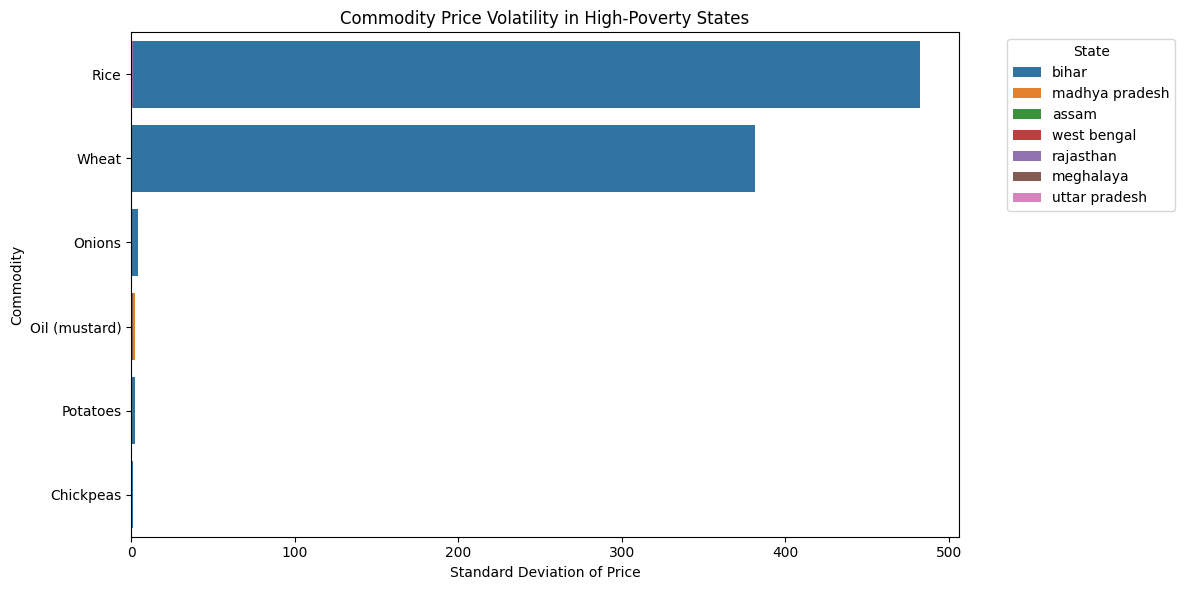

In [27]:
# Commodity Volatility in High-Poverty States
high_poverty = df_poverty_matched[df_poverty_matched["multidimensional_poverty_index"] > 0.3]

volatility = high_poverty.groupby(["state_name", "commodity"])["price_local"].std().reset_index()
volatility = volatility.sort_values(by="price_local", ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x="price_local", y="commodity", hue="state_name", data=volatility, dodge=False)
plt.title("Commodity Price Volatility in High-Poverty States")
plt.xlabel("Standard Deviation of Price")
plt.ylabel("Commodity")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Outlier Detection
#### This reveals markets where prices are disproportionately high relative to poverty levels.

In [ ]:
# Outlier Detection – Price to Poverty Ratio
outliers = df_poverty_matched[df_poverty_matched["price_to_poverty_ratio"] > 100]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=outliers, x="poverty_headcount_ratio", y="price_local", hue="state_name", alpha=0.7)
plt.title("Outliers: Price vs. Poverty Headcount Ratio")
plt.xlabel("Poverty Headcount Ratio")
plt.ylabel("Price")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Regression Modeling

### Goal
#### Predict poverty-weighted price based on commodity, location, and poverty indicators. 
#### This helps forecast economic burden in vulnerable regions.

#### - Prepare the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Filter rows with complete data
df_model = df_poverty_matched.dropna(subset=[
    "poverty_weighted_price", "price_local", "multidimensional_poverty_index",
    "poverty_headcount_ratio", "commodity", "state_name"
])

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_model[[
    "commodity", "state_name"
]], drop_first=True)

# Combine with numeric features
X = pd.concat([
    df_encoded,
    df_model[["price_local", "multidimensional_poverty_index", "poverty_headcount_ratio"]]
], axis=1)

y = df_model["poverty_weighted_price"]

#### - Train the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#### - Evaluate performance

In [ ]:
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Clustering

### Group regions or commodities based on shared patterns in:

 - Poverty indicators

 - Price behavior

 - Derived features like poverty_weighted_price and price_to_poverty_ratio

Helps in :

 - Identify high-risk clusters

 - Build intuitive filters for dashboards

 - Add unsupervised learning to your portfolio

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features for clustering
features = df_poverty_matched[[
    "multidimensional_poverty_index",
    "poverty_headcount_ratio",
    "poverty_weighted_price",
    "price_to_poverty_ratio"
]].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#### - Run KMeans Clustering

In [ ]:
# Choose number of clusters (start with 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df_poverty_matched["cluster"] = pd.Series(clusters, index=features.index)


#### - Visualize Cluster

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_poverty_matched,
    x="poverty_headcount_ratio",
    y="poverty_weighted_price",
    hue="cluster",
    palette="Set2",
    alpha=0.7
)
plt.title("Clusters of Vulnerability Profiles")
plt.xlabel("Poverty Headcount Ratio")
plt.ylabel("Poverty-Weighted Price")
plt.tight_layout()
plt.show()


In [ ]:
cluster_summary = df_poverty_matched.groupby("cluster")[[
    "multidimensional_poverty_index",
    "poverty_headcount_ratio",
    "poverty_weighted_price",
    "price_to_poverty_ratio"
]].mean().round(2)

cluster_summary.reset_index()
cluster_summary

In [28]:
df.to_csv("food_poverty_joined.csv", index=False)